# Deep Q-Network

## GridWorld

In [1]:
from gridworld.gridworld import GridWorld

env = GridWorld(4)
env.reset(seed=42)
env.render()

[['W', '.', '.', '.'],
 ['.', 'P', '.', '.'],
 ['.', '+', '.', '.'],
 ['-', '.', '.', '.']]

In [2]:
# 0: up, 1: down, 2: left, 3: right
ob, reward, terminated, truncated, info = env.step(0)
print("reward: {} | terminated: {}".format(reward, terminated))
env.render()

reward: -1 | terminated: False


[['W', 'P', '.', '.'],
 ['.', '.', '.', '.'],
 ['.', '+', '.', '.'],
 ['-', '.', '.', '.']]

In [3]:
ob, reward, terminated, truncated, info = env.step(1)
print("reward: {} | terminated: {}".format(reward, terminated))
env.render()

reward: -1 | terminated: False


[['W', '.', '.', '.'],
 ['.', 'P', '.', '.'],
 ['.', '+', '.', '.'],
 ['-', '.', '.', '.']]

In [4]:
ob, reward, terminated, truncated, info = env.step(1)
print("reward: {} | terminated: {}".format(reward, terminated))
env.render()

reward: 10 | terminated: True


[['W', '.', '.', '.'],
 ['.', '.', '.', '.'],
 ['.', 'P', '.', '.'],
 ['-', '.', '.', '.']]

In [5]:
# Each row represents the index of the pieces on the tile in the order:
# player, goal, pit, wall
env.observation

[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0]],
 [[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]]

In [6]:
import numpy as np

assert np.array(env.observation).shape == (4, 4, 4)

## Neural Network Q Function

In [7]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from gridworld.gridworld import GridWorld
from tqdm.notebook import tqdm, trange

In [8]:
def make_model():
    model = torch.nn.Sequential(
        # Input is our gridworld state, a 1x64 grid representation.
        torch.nn.Linear(64, 150),
        torch.nn.ReLU(),
        torch.nn.Linear(150, 100),
        torch.nn.ReLU(),
        # Output is the expected rewards for each arm: 0: up, 1: down, 2: left, 3: right
        torch.nn.Linear(100, 4),
    )
    return model

In [9]:
model = make_model()

In [10]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
def dqn(model, optimizer, epoch=1000, epsilon=1.0, gamma=0.9, seed=None):
    noise = lambda: torch.rand(1, 64) / 64
    losses = []
    for i in trange(epoch):
        env = GridWorld(size=4)
        env.reset(seed=seed)  # Static board.

        # Initial state, with noise.
        observation = env.observation
        while True:
            state = torch.Tensor(observation).view(-1, 64) + noise()
            q_val = model(state)
            if np.random.random() < epsilon:  # Exploration
                action = torch.randint(4, (1,)).item()
            else:
                action = torch.argmax(q_val, dim=1).item()
            observation, reward, terminated, _truncated, _info = env.step(action)
            if not terminated:
                state = torch.Tensor(observation).view(-1, 64) + noise()
                with torch.no_grad():
                    next_q_val = model(state)
                max_q = torch.max(next_q_val)
                reward = reward + gamma * max_q

            y_pred = torch.Tensor([reward])
            y_true = q_val[:, action]
            loss = loss_fn(y_pred, y_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            if terminated:
                break
        if epsilon > 0.1:
            epsilon -= 1 / epoch
    return losses

  0%|          | 0/1000 [00:00<?, ?it/s]

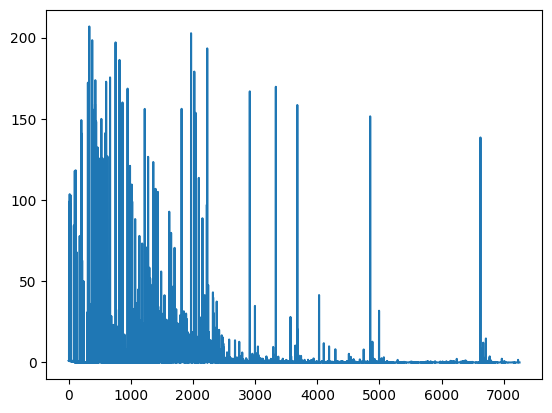

In [12]:
losses = dqn(model, optimizer, epoch=1000, seed=33)  # Static board
plt.plot(np.arange(len(losses)), losses);

In [13]:
def test_dqn(model, epoch=32):
    env = GridWorld(size=4)
    env.reset(seed=33)  # Static board.

    # Initial state, with noise.
    observation = env.observation
    for i in trange(epoch):
        print("Step: {}".format(i))
        print("\n".join(list(map(lambda row: "".join(row), env.render()))))
        print()
        state = torch.Tensor(observation).view(-1, 64)
        with torch.no_grad():
            q_val = model(state)
        action = torch.argmax(q_val, dim=1).item()
        observation, reward, terminated, _truncated, _info = env.step(action)
        if terminated:
            print("DONE")
            break

In [14]:
test_dqn(model)

  0%|          | 0/32 [00:00<?, ?it/s]

Step: 0
....
.+-.
...P
...W

Step: 1
....
.+-.
..P.
...W

Step: 2
....
.+-.
.P..
...W

DONE


  0%|          | 0/1000 [00:00<?, ?it/s]

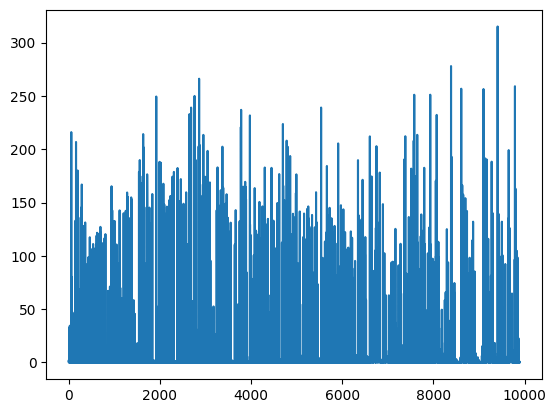

In [15]:
losses = dqn(model, optimizer, epoch=1000, seed=None)  # Random board
plt.plot(np.arange(len(losses)), losses);

## Experience Replay

In [16]:
from collections import deque


def dqn_experience_replay(model, optimizer, epochs=1000, gamma=0.9, epsilon=1.0):
    replay = deque(maxlen=1000)
    batch_size = 200
    max_moves = 50
    losses = []
    noise = lambda: torch.rand(1, 64) / 64

    for _ in trange(epochs):
        env = GridWorld(4)
        env.reset(seed=None)  # Random state

        observation = env.observation
        for _ in range(max_moves):
            state = torch.Tensor(observation).view(-1, 64) + noise()
            q_val = model(state)
            if np.random.random() < epsilon:
                action = torch.randint(4, (1,)).item()
            else:
                action = torch.argmax(q_val, dim=1).item()
            observation, reward, terminated, _truncated, _info = env.step(action)
            replay.append(
                (
                    state,
                    action,
                    reward,
                    torch.Tensor(observation).view(-1, 64),
                    terminated,
                )
            )

            if len(replay) > batch_size:
                # Experience replay.
                batch = random.sample(replay, batch_size)
                (
                    state1_batch,
                    action_batch,
                    reward_batch,
                    state2_batch,
                    terminated_batch,
                ) = list(zip(*batch))
                state1_batch = torch.cat(state1_batch)
                action_batch = torch.Tensor(action_batch)
                reward_batch = torch.Tensor(reward_batch)
                state2_batch = torch.cat(state2_batch)
                terminated_batch = torch.Tensor(terminated_batch)
                q_val = model(state1_batch)
                with torch.no_grad():
                    q_val_next = model(state2_batch)
                y_pred = (
                    reward_batch
                    + gamma * (1 - terminated_batch) * torch.max(q_val_next, dim=1)[0]
                )
                y_true = q_val.gather(
                    dim=1, index=action_batch.unsqueeze(dim=1).long()
                ).squeeze()
                loss = loss_fn(y_pred, y_true)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            if terminated:
                break
        if epsilon > 0.1:
            epsilon -= 1 / epochs
    return losses

In [17]:
# The first item is the values, the second is the index
torch.max(torch.Tensor([[1, 2, 3], [3, 5, 6]]), dim=1)

torch.return_types.max(
values=tensor([3., 6.]),
indices=tensor([2, 2]))

In [18]:
torch.max(torch.Tensor([[1, 2, 3], [3, 5, 6]]), dim=0)

torch.return_types.max(
values=tensor([3., 5., 6.]),
indices=tensor([1, 1, 1]))

In [19]:
torch.max(torch.Tensor([[1, 2, 3], [3, 5, 6]]))

tensor(6.)

In [20]:
model = make_model()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  0%|          | 0/5000 [00:00<?, ?it/s]

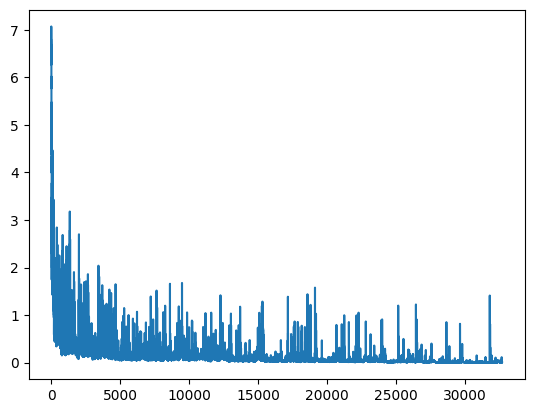

In [21]:
losses = dqn_experience_replay(model, optimizer, epochs=5000)
plt.plot(np.arange(len(losses)), losses)

In [22]:
def test_dqn_experience_replay(model, epoch=1000, max_moves=50):
    wins = 0
    loss = 0
    limbo = 0
    for _ in trange(epoch):
        env = GridWorld(4)
        env.reset(seed=None)  # Random state

        observation = env.observation
        for _ in range(max_moves):
            state = torch.Tensor(observation).view(-1, 64)
            q_val = model(state)
            action = torch.argmax(q_val, dim=1).item()
            observation, reward, terminated, _truncated, _info = env.step(action)
            if terminated:
                break
        if reward == 10:
            wins += 1
        if reward == -10:
            loss += 1
        if reward == -1:
            print()
            print(np.array(env.render()))
            limbo += 1
    return wins, loss, limbo

In [23]:
win, loss, limbo = test_dqn_experience_replay(model, max_moves=50)
win, loss, limbo

  0%|          | 0/1000 [00:00<?, ?it/s]


[['.' '.' '.' '.']
 ['.' '.' '-' '+']
 ['W' '.' '.' '.']
 ['.' 'P' '.' '.']]

[['-' 'W' '.' '.']
 ['+' '.' '.' '.']
 ['.' '.' '.' 'P']
 ['.' '.' '.' '.']]

[['.' '.' 'P' '.']
 ['.' '.' '.' '.']
 ['.' '.' 'W' '.']
 ['+' '.' '-' '.']]

[['.' 'P' '.' '.']
 ['.' '-' '.' '.']
 ['.' 'W' '.' '.']
 ['.' '+' '.' '.']]

[['.' '.' '.' '.']
 ['.' '+' '-' 'P']
 ['W' '.' '.' '.']
 ['.' '.' '.' '.']]

[['.' '.' 'W' '.']
 ['.' '+' '.' '.']
 ['.' '.' '-' 'P']
 ['.' '.' '.' '.']]

[['-' '.' '.' '.']
 ['+' '.' '.' '.']
 ['.' '.' 'W' 'P']
 ['.' '.' '.' '.']]


(993, 0, 7)

## Target Network

In [24]:
import copy

model = make_model()
# https://discuss.pytorch.org/t/are-there-any-recommended-methods-to-clone-a-model/483/4
target = copy.deepcopy(model)
target.load_state_dict(model.state_dict())

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [25]:
def dqn_target_network(
    model, target, optimizer, sync_freq=500, epochs=5000, epsilon=1.0, gamma=0.9
):
    losses = []
    mem_size = 1000
    batch_size = 200
    replay = deque(maxlen=mem_size)
    max_moves = 50
    noise = lambda: torch.rand(1, 64) / 64

    freq = 0

    for _ in trange(epochs):
        env = GridWorld(4)
        env.reset(seed=None)  # Random state

        observation = env.observation
        for _ in range(max_moves):
            state = torch.Tensor(observation).view(-1, 64) + noise()
            q_val = model(state)
            if np.random.random() < epsilon:
                action = torch.randint(4, (1,)).item()
            else:
                action = torch.argmax(q_val, dim=1).item()

            observation, reward, terminated, _truncated, _info = env.step(action)
            replay.append(
                (
                    state,
                    action,
                    reward,
                    torch.Tensor(observation).view(-1, 64),
                    terminated,
                )
            )
            if len(replay) > batch_size:
                batch = random.sample(replay, batch_size)
                (
                    state1_batch,
                    action_batch,
                    reward_batch,
                    state2_batch,
                    terminated_batch,
                ) = list(zip(*batch))
                state1_batch = torch.cat(state1_batch)
                action_batch = torch.Tensor(action_batch)
                reward_batch = torch.Tensor(reward_batch)
                state2_batch = torch.cat(state2_batch)
                terminated_batch = torch.Tensor(terminated_batch)

                q_val = model(state1_batch)
                with torch.no_grad():
                    q_val_next = target(state2_batch)
                y_pred = (
                    reward_batch
                    + gamma * (1 - terminated_batch) * torch.max(q_val_next, dim=1)[0]
                )
                y_true = q_val.gather(
                    dim=1, index=action_batch.unsqueeze(dim=1).long()
                ).squeeze()
                loss = loss_fn(y_pred, y_true)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

                if freq % sync_freq == 0:
                    target.load_state_dict(model.state_dict())
                if terminated:
                    break
            freq += 1
        if epsilon > 0.1:
            epsilon -= 1 / epochs
    return losses

  0%|          | 0/5000 [00:00<?, ?it/s]

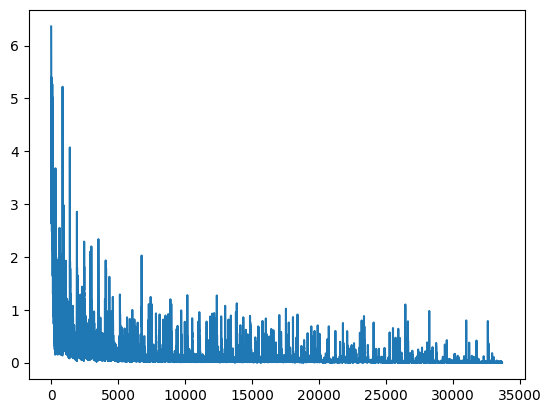

In [26]:
losses = dqn_target_network(model, target, optimizer, epochs=5000)
plt.plot(np.arange(len(losses)), losses);

In [27]:
def test_dqn_target_network(model, epoch=1000, max_moves=50):
    wins = 0
    loss = 0
    limbo = 0
    for _ in trange(epoch):
        env = GridWorld(4)
        env.reset(seed=None)  # Random state

        observation = env.observation
        for _ in range(max_moves):
            state = torch.Tensor(observation).view(-1, 64)
            q_val = model(state)
            action = torch.argmax(q_val, dim=1).item()
            observation, reward, terminated, _truncated, _info = env.step(action)
            if terminated:
                break
        if reward == 10:
            wins += 1
        if reward == -10:
            loss += 1
        if reward == -1:
            print()
            print(np.array(env.render()))
            limbo += 1
    return wins, loss, limbo

In [28]:
wins, loss, limbo = test_dqn_target_network(model)
wins, loss, limbo

  0%|          | 0/1000 [00:00<?, ?it/s]


[['W' 'P' '.' '.']
 ['.' '.' '.' '.']
 ['.' '.' '-' '+']
 ['.' '.' '.' '.']]


(999, 0, 1)